In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from model_trainer import LabelTransferTrainer

In [2]:
datasets = pd.read_csv('datasets.csv')
datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

trainer = LabelTransferTrainer(hyperparams_file='hyperparams.csv',
                               data_dir='exported_matrices',
                               output_dir='label_transfer_model_output',
                               verbose=False,
                               random_seed=12345)

# Hyperparameter tuning

In [3]:
print(datasets['study_id'].unique())

['Ruf_Zamojski2021F' 'Ruf_Zamojski2021M' 'Lopez2021M' 'Allensworth2021F'
 'Vennekens2021M' 'Mayran2019M' 'Cheung2018M' 'Kucka2021F' 'Fletcher2019F'
 'Fletcher2019M']


In [4]:
study_id = 'Fletcher2019M'
do_hyperparam_search = False
single_param_search = False

Sweep through the hyperparameters of the model to find the best combination of hyperparameters.

In [5]:
# valid_hyperparameters = ['learning_rate', 'max_depth', 'n_boost_rounds', 'gamma']

if do_hyperparam_search:
    # We recreate the trainer object here in case we changed the hyperparams
    trainer = LabelTransferTrainer(hyperparams_file='hyperparams.csv',
                                      data_dir='exported_matrices',
                                      output_dir='label_transfer_model_output',
                                      verbose=False,
                                      random_seed=12345)

    if single_param_search:
        # Single hyperparameter
        param = "learning_rate"
        values = [0.001, 0.01, 0.1, 0.5]
        
        res = trainer.tune_hyperparam(study_id, param, values, n_folds=5)
    else:        
        # Two hyperparameters
        param1 = "learning_rate"
        param2 = "max_depth"
        values1 = [0.001, 0.01, 0.1, 0.5]
        values2 = [3, 5, 7, 9]
        
        res = trainer.tune_two_hyperparameters(study_id, param1, param2, values1, values2, n_folds=5)    


In [6]:
# Plot the results
# The results are saved in a pd dataframe with the following columns:
#   - <hyperparam>: the value of hyperparameter that was tuned
#   - Fold: the fold number
#   - Epoch: the epoch number
#   - Loss, Val loss: the training and validation loss
#   - F1 score, Val F1 score: the training and validation F1 score

if do_hyperparam_search:
    if single_param_search:
        # Single hyperparameter
        res_grouped = res.groupby(param)
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        for param_value, group in res_grouped:
            mean_group = group.groupby("Epoch").mean(numeric_only=True)
            min_group = group.groupby("Epoch").min()
            max_group = group.groupby("Epoch").max()
            print(mean_group)
            sns.lineplot(data=mean_group, x="Epoch", y="Macro F1 score",
                         ax=ax[0], label=f"{param}={param_value}")
            sns.lineplot(data=mean_group, x="Epoch", y="Val Macro F1 score",
                         ax=ax[1], label=f"{param}={param_value}")

            ax[0].fill_between(
                mean_group.index, min_group["Macro F1 score"], max_group["Macro F1 score"], alpha=0.1)
            ax[1].fill_between(
                mean_group.index, min_group["Val Macro F1 score"], max_group["Val Macro F1 score"], alpha=0.1)
            plt.ylim(0, 1)

        # Plot average F1 score
        ax[0].plot(res_grouped.mean()["Epoch"], res_grouped.mean()[
                   "Macro F1 score"], label="Average - train", color='C1')
        ax[1].plot(res_grouped.mean()["Epoch"], res_grouped.mean()[
                   "Val Macro F1 score"], label="Average - validation", color='C1')
        # ax[1].plot(group["Epoch"], group["Val Macro F1 score"], color='C0')

        plt.title(f"F1 score vs {param}")
    else:
        # Two hyperparameters
        res_grouped = res.groupby([param1, param2])
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        # Heatmap of max F1 for each pair of parameters
        max_f1 = res_grouped["Val Macro F1 score"].max().unstack()
        sns.heatmap(max_f1, annot=True, ax=ax[0], cmap='viridis')
        ax[0].set_title("Max F1 score")
        ax[0].set_xlabel(param2)
        ax[0].set_ylabel(param1)

        # Plot of F1 over epochs for max of param 1
        # Get the values of param1 and param2 that give max F1
        max_p1 = max_f1.idxmax(axis=0)[values2[0]]

        for param2_value in values2:
            group = res_grouped.get_group((max_p1, param2_value))
            mean_group = group.groupby("Epoch").mean(numeric_only=True)
            min_group = group.groupby("Epoch").min(numeric_only=True)
            max_group = group.groupby("Epoch").max(numeric_only=True)
            sns.lineplot(data=mean_group, x="Epoch", y="Val Macro F1 score",
                         ax=ax[1], label=f"{param2}={param2_value}")
            ax[1].fill_between(
                mean_group.index, min_group["Val Macro F1 score"], max_group["Val Macro F1 score"], alpha=0.1)
        ax[1].set_title(f"Macro F1 score vs {param2} for {param1}={max_p1}")

        # Plot of F1 over epochs for max of param 2
        max_p2 = max_f1.idxmax(axis=1)[values1[0]]

        for param1_value in values1:
            group = res_grouped.get_group((param1_value, max_p2))
            mean_group = group.groupby("Epoch").mean(numeric_only=True)
            min_group = group.groupby("Epoch").min(numeric_only=True)
            max_group = group.groupby("Epoch").max(numeric_only=True)
            sns.lineplot(data=mean_group, x="Epoch", y="Val Macro F1 score",
                         ax=ax[2], label=f"{param1}={param1_value}")
            ax[2].fill_between(
                mean_group.index, min_group["Val Macro F1 score"], max_group["Val Macro F1 score"], alpha=0.1)
        ax[2].set_title(f"F1 score vs {param1} for {param2}={max_p2}")

    plt.show()

In [7]:
keras.backend.clear_session()
# We recreate the trainer object here in case we changed the hyperparams
trainer = LabelTransferTrainer(hyperparams_file='hyperparams.csv',
                            data_dir='exported_matrices',
                            output_dir='label_transfer_model_output',
                            verbose=False,
                            random_seed=12345) 
    
trainer.models[study_id], history = trainer.train_single_model(study_id)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax.flat[0].plot(history['loss'], label='train')
ax.flat[0].plot(history['val_loss'], label='validation')
ax.flat[0].set_xlabel('Epoch')
ax.flat[0].set_ylabel('Loss')

ax.flat[1].plot(history['macro_f1_score'], label='train')
ax.flat[1].plot(history['val_macro_f1_score'], label='validation')
ax.flat[1].set_xlabel('Epoch')
ax.flat[1].set_ylabel('F1 score (macro)')

ax.flat[2].plot(history['micro_f1_score'], label='train')
ax.flat[2].plot(history['val_micro_f1_score'], label='validation')
ax.flat[2].set_xlabel('Epoch')
ax.flat[2].set_ylabel('F1 score (micro)')

ax.flat[3].plot(history['ROCAUC'], label='train')
ax.flat[3].plot(history['val_ROCAUC'], label='validation')
ax.flat[3].set_xlabel('Epoch')
ax.flat[3].set_ylabel('ROC AUC')

for a in ax.flat[2:]:
    a.set_ylim(0, 1.1)
    a.legend()

plt.tight_layout()

eval_res = trainer.evaluate_single_model(study_id)
metrics_names = ['loss', 'accuracy', 'micro_f1_score', 'macro_f1_score', 'ROCAUC']

eval_res = dict(zip(metrics_names, eval_res))
for key, val in eval_res.items():
    print(f"{key}: {val:.3f}")

NameError: name 'keras' is not defined

# Training

In [8]:
retrain_all = True
clear_saved_models = False

# We recreate the trainer object here in case we changed the hyperparams
trainer = LabelTransferTrainer(hyperparams_file='hyperparams.csv',
                            data_dir='exported_matrices',
                            output_dir='label_transfer_model_output',
                            verbose=True,
                            random_seed=12345) 

# Uncomment to delete all saved model files
if retrain_all:
    if clear_saved_models:
        trainer.clear_saved_models()
    trainer.train_all_models()
else:
    trainer.load_best_models()

Data directory: exported_matrices/
Output directory: label_transfer_model_output/
Loaded hyperparameters for 10 models.
Training model Allensworth2021F for 150 rounds...


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.68470	train-auc:0.99228	eval-mlogloss:1.72485	eval-auc:0.93913
[1]	train-mlogloss:1.48182	train-auc:0.99636	eval-mlogloss:1.56262	eval-auc:0.95191
[2]	train-mlogloss:1.32118	train-auc:0.99751	eval-mlogloss:1.43298	eval-auc:0.95385
[3]	train-mlogloss:1.18929	train-auc:0.99819	eval-mlogloss:1.32078	eval-auc:0.95742
[4]	train-mlogloss:1.07299	train-auc:0.99867	eval-mlogloss:1.22304	eval-auc:0.96353
[5]	train-mlogloss:0.97290	train-auc:0.99897	eval-mlogloss:1.14005	eval-auc:0.96656
[6]	train-mlogloss:0.88682	train-auc:0.99913	eval-mlogloss:1.06930	eval-auc:0.96680
[7]	train-mlogloss:0.81168	train-auc:0.99942	eval-mlogloss:1.00905	eval-auc:0.96689
[8]	train-mlogloss:0.74145	train-auc:0.99957	eval-mlogloss:0.95093	eval-auc:0.96801
[9]	train-mlogloss:0.67898	train-auc:0.99972	eval-mlogloss:0.89940	eval-auc:0.96968
[10]	train-mlogloss:0.62311	train-auc:0.99981	eval-mlogloss:0.85698	eval-auc:0.96955
[11]	train-mlogloss:0.57387	train-auc:0.99986	eval-mlogloss:0.81676	eval-au

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mlogloss:1.26511	train-auc:0.99843	eval-mlogloss:1.36813	eval-auc:0.92740
[2]	train-mlogloss:1.13621	train-auc:0.99946	eval-mlogloss:1.27634	eval-auc:0.94537
[3]	train-mlogloss:1.02290	train-auc:0.99980	eval-mlogloss:1.20159	eval-auc:0.94400
[4]	train-mlogloss:0.92739	train-auc:0.99987	eval-mlogloss:1.13562	eval-auc:0.94829
[5]	train-mlogloss:0.84263	train-auc:0.99991	eval-mlogloss:1.07508	eval-auc:0.95246
[6]	train-mlogloss:0.76853	train-auc:0.99993	eval-mlogloss:1.02569	eval-auc:0.95220
[7]	train-mlogloss:0.70190	train-auc:0.99999	eval-mlogloss:0.97897	eval-auc:0.95467
[8]	train-mlogloss:0.64221	train-auc:1.00000	eval-mlogloss:0.93795	eval-auc:0.95641
[9]	train-mlogloss:0.58993	train-auc:1.00000	eval-mlogloss:0.90079	eval-auc:0.95865
[10]	train-mlogloss:0.54265	train-auc:0.99999	eval-mlogloss:0.86398	eval-auc:0.96033
[11]	train-mlogloss:0.49898	train-auc:1.00000	eval-mlogloss:0.83633	eval-auc:0.96036
[12]	train-mlogloss:0.46052	train-auc:1.00000	eval-mlogloss:0.80665	eval-a

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mlogloss:0.87445	train-auc:0.99971	eval-mlogloss:0.96248	eval-auc:0.88264
[2]	train-mlogloss:0.78428	train-auc:0.99995	eval-mlogloss:0.90942	eval-auc:0.90602
[3]	train-mlogloss:0.70760	train-auc:0.99996	eval-mlogloss:0.86280	eval-auc:0.90588
[4]	train-mlogloss:0.63934	train-auc:0.99998	eval-mlogloss:0.81974	eval-auc:0.91183
[5]	train-mlogloss:0.57957	train-auc:0.99999	eval-mlogloss:0.78474	eval-auc:0.91745
[6]	train-mlogloss:0.52729	train-auc:0.99999	eval-mlogloss:0.75272	eval-auc:0.91957
[7]	train-mlogloss:0.47827	train-auc:1.00000	eval-mlogloss:0.72548	eval-auc:0.92222
[8]	train-mlogloss:0.43537	train-auc:1.00000	eval-mlogloss:0.69778	eval-auc:0.92461
[9]	train-mlogloss:0.39701	train-auc:1.00000	eval-mlogloss:0.66999	eval-auc:0.92830
[10]	train-mlogloss:0.36226	train-auc:1.00000	eval-mlogloss:0.64309	eval-auc:0.93257
[11]	train-mlogloss:0.33121	train-auc:1.00000	eval-mlogloss:0.61791	eval-auc:0.93723
[12]	train-mlogloss:0.30309	train-auc:1.00000	eval-mlogloss:0.59383	eval-a

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mlogloss:1.12103	train-auc:0.99190	eval-mlogloss:1.18436	eval-auc:0.93342
[2]	train-mlogloss:1.01248	train-auc:0.99468	eval-mlogloss:1.11427	eval-auc:0.93277
[3]	train-mlogloss:0.92295	train-auc:0.99698	eval-mlogloss:1.04517	eval-auc:0.94078
[4]	train-mlogloss:0.84158	train-auc:0.99787	eval-mlogloss:0.98885	eval-auc:0.93812
[5]	train-mlogloss:0.76757	train-auc:0.99891	eval-mlogloss:0.93889	eval-auc:0.94148
[6]	train-mlogloss:0.70145	train-auc:0.99927	eval-mlogloss:0.89751	eval-auc:0.94100
[7]	train-mlogloss:0.64455	train-auc:0.99947	eval-mlogloss:0.85340	eval-auc:0.94375
[8]	train-mlogloss:0.59220	train-auc:0.99961	eval-mlogloss:0.81762	eval-auc:0.94332
[9]	train-mlogloss:0.54214	train-auc:0.99982	eval-mlogloss:0.78471	eval-auc:0.94469
[10]	train-mlogloss:0.49854	train-auc:0.99988	eval-mlogloss:0.75471	eval-auc:0.94569
[11]	train-mlogloss:0.45894	train-auc:0.99993	eval-mlogloss:0.72682	eval-auc:0.94647
[12]	train-mlogloss:0.42234	train-auc:0.99995	eval-mlogloss:0.70373	eval-a

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.80742	train-auc:0.98252	eval-mlogloss:1.85835	eval-auc:0.91662
[1]	train-mlogloss:1.60164	train-auc:0.99039	eval-mlogloss:1.69790	eval-auc:0.93256
[2]	train-mlogloss:1.43913	train-auc:0.99311	eval-mlogloss:1.56875	eval-auc:0.93723
[3]	train-mlogloss:1.30095	train-auc:0.99515	eval-mlogloss:1.45713	eval-auc:0.94254
[4]	train-mlogloss:1.18427	train-auc:0.99640	eval-mlogloss:1.36799	eval-auc:0.94545
[5]	train-mlogloss:1.08233	train-auc:0.99715	eval-mlogloss:1.28889	eval-auc:0.94860
[6]	train-mlogloss:0.99238	train-auc:0.99777	eval-mlogloss:1.21864	eval-auc:0.95102
[7]	train-mlogloss:0.91466	train-auc:0.99808	eval-mlogloss:1.15920	eval-auc:0.95128
[8]	train-mlogloss:0.84428	train-auc:0.99846	eval-mlogloss:1.10487	eval-auc:0.95211
[9]	train-mlogloss:0.78154	train-auc:0.99875	eval-mlogloss:1.05343	eval-auc:0.95371
[10]	train-mlogloss:0.72257	train-auc:0.99900	eval-mlogloss:1.00995	eval-auc:0.95422
[11]	train-mlogloss:0.67037	train-auc:0.99925	eval-mlogloss:0.97164	eval-au

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mlogloss:1.10272	train-auc:0.99952	eval-mlogloss:1.24782	eval-auc:0.81491
[2]	train-mlogloss:0.99228	train-auc:1.00000	eval-mlogloss:1.20124	eval-auc:0.82410
[3]	train-mlogloss:0.89734	train-auc:1.00000	eval-mlogloss:1.15969	eval-auc:0.82804
[4]	train-mlogloss:0.81360	train-auc:1.00000	eval-mlogloss:1.12458	eval-auc:0.82687
[5]	train-mlogloss:0.73946	train-auc:1.00000	eval-mlogloss:1.09941	eval-auc:0.83150
[6]	train-mlogloss:0.67287	train-auc:1.00000	eval-mlogloss:1.07664	eval-auc:0.83301
[7]	train-mlogloss:0.61312	train-auc:1.00000	eval-mlogloss:1.05759	eval-auc:0.83532
[8]	train-mlogloss:0.56134	train-auc:1.00000	eval-mlogloss:1.03653	eval-auc:0.83732
[9]	train-mlogloss:0.51556	train-auc:1.00000	eval-mlogloss:1.01678	eval-auc:0.84476
[10]	train-mlogloss:0.47220	train-auc:1.00000	eval-mlogloss:0.99930	eval-auc:0.84832
[11]	train-mlogloss:0.43281	train-auc:1.00000	eval-mlogloss:0.98334	eval-auc:0.84729
[12]	train-mlogloss:0.40009	train-auc:1.00000	eval-mlogloss:0.96985	eval-a

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mlogloss:1.28562	train-auc:0.99719	eval-mlogloss:1.45434	eval-auc:0.82511
[2]	train-mlogloss:1.16056	train-auc:0.99852	eval-mlogloss:1.39280	eval-auc:0.83145
[3]	train-mlogloss:1.05436	train-auc:0.99897	eval-mlogloss:1.33645	eval-auc:0.84200
[4]	train-mlogloss:0.96400	train-auc:0.99942	eval-mlogloss:1.28371	eval-auc:0.85326
[5]	train-mlogloss:0.88297	train-auc:0.99961	eval-mlogloss:1.24225	eval-auc:0.85621
[6]	train-mlogloss:0.81121	train-auc:0.99970	eval-mlogloss:1.20395	eval-auc:0.85975
[7]	train-mlogloss:0.74656	train-auc:0.99975	eval-mlogloss:1.18000	eval-auc:0.85680
[8]	train-mlogloss:0.68821	train-auc:0.99982	eval-mlogloss:1.14979	eval-auc:0.85898
[9]	train-mlogloss:0.63594	train-auc:0.99986	eval-mlogloss:1.12215	eval-auc:0.86000
[10]	train-mlogloss:0.58648	train-auc:0.99994	eval-mlogloss:1.09786	eval-auc:0.86435
[11]	train-mlogloss:0.54318	train-auc:0.99997	eval-mlogloss:1.07763	eval-auc:0.86707
[12]	train-mlogloss:0.50487	train-auc:0.99999	eval-mlogloss:1.05763	eval-a

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.80292	train-auc:0.98225	eval-mlogloss:1.84165	eval-auc:0.92906
[1]	train-mlogloss:1.59336	train-auc:0.98904	eval-mlogloss:1.66554	eval-auc:0.94379
[2]	train-mlogloss:1.42624	train-auc:0.99198	eval-mlogloss:1.52800	eval-auc:0.95024
[3]	train-mlogloss:1.28613	train-auc:0.99408	eval-mlogloss:1.41121	eval-auc:0.95677
[4]	train-mlogloss:1.16953	train-auc:0.99517	eval-mlogloss:1.31463	eval-auc:0.95676
[5]	train-mlogloss:1.06623	train-auc:0.99594	eval-mlogloss:1.22662	eval-auc:0.95923
[6]	train-mlogloss:0.97683	train-auc:0.99641	eval-mlogloss:1.15505	eval-auc:0.95948
[7]	train-mlogloss:0.89773	train-auc:0.99734	eval-mlogloss:1.09061	eval-auc:0.96130
[8]	train-mlogloss:0.82488	train-auc:0.99777	eval-mlogloss:1.03118	eval-auc:0.96406
[9]	train-mlogloss:0.76003	train-auc:0.99810	eval-mlogloss:0.97907	eval-auc:0.96503
[10]	train-mlogloss:0.70228	train-auc:0.99833	eval-mlogloss:0.93360	eval-auc:0.96558
[11]	train-mlogloss:0.65098	train-auc:0.99858	eval-mlogloss:0.89506	eval-au

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.90706	train-auc:0.98671	eval-mlogloss:1.95944	eval-auc:0.93376
[1]	train-mlogloss:1.68837	train-auc:0.99370	eval-mlogloss:1.78971	eval-auc:0.94484
[2]	train-mlogloss:1.51442	train-auc:0.99519	eval-mlogloss:1.65024	eval-auc:0.95488
[3]	train-mlogloss:1.36796	train-auc:0.99687	eval-mlogloss:1.53196	eval-auc:0.96228
[4]	train-mlogloss:1.23978	train-auc:0.99781	eval-mlogloss:1.42932	eval-auc:0.96820
[5]	train-mlogloss:1.13068	train-auc:0.99857	eval-mlogloss:1.33842	eval-auc:0.97264
[6]	train-mlogloss:1.03087	train-auc:0.99895	eval-mlogloss:1.25529	eval-auc:0.97725
[7]	train-mlogloss:0.94581	train-auc:0.99915	eval-mlogloss:1.18204	eval-auc:0.97962
[8]	train-mlogloss:0.87123	train-auc:0.99928	eval-mlogloss:1.11621	eval-auc:0.98081
[9]	train-mlogloss:0.80391	train-auc:0.99942	eval-mlogloss:1.05904	eval-auc:0.98190
[10]	train-mlogloss:0.74309	train-auc:0.99954	eval-mlogloss:1.00629	eval-auc:0.98231
[11]	train-mlogloss:0.68743	train-auc:0.99961	eval-mlogloss:0.95958	eval-au

/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mlogloss:1.09827	train-auc:0.99969	eval-mlogloss:1.21784	eval-auc:0.87939
[2]	train-mlogloss:0.98394	train-auc:0.99992	eval-mlogloss:1.14775	eval-auc:0.89619
[3]	train-mlogloss:0.88616	train-auc:0.99999	eval-mlogloss:1.08747	eval-auc:0.90945
[4]	train-mlogloss:0.80039	train-auc:0.99999	eval-mlogloss:1.02882	eval-auc:0.92071
[5]	train-mlogloss:0.72409	train-auc:1.00000	eval-mlogloss:0.98279	eval-auc:0.92468
[6]	train-mlogloss:0.65630	train-auc:1.00000	eval-mlogloss:0.93425	eval-auc:0.92979
[7]	train-mlogloss:0.59543	train-auc:1.00000	eval-mlogloss:0.89002	eval-auc:0.93812
[8]	train-mlogloss:0.54198	train-auc:1.00000	eval-mlogloss:0.85224	eval-auc:0.94242
[9]	train-mlogloss:0.49480	train-auc:1.00000	eval-mlogloss:0.81199	eval-auc:0.94789
[10]	train-mlogloss:0.45226	train-auc:1.00000	eval-mlogloss:0.77724	eval-auc:0.95090
[11]	train-mlogloss:0.41386	train-auc:1.00000	eval-mlogloss:0.74665	eval-auc:0.95266
[12]	train-mlogloss:0.37932	train-auc:1.00000	eval-mlogloss:0.71936	eval-a

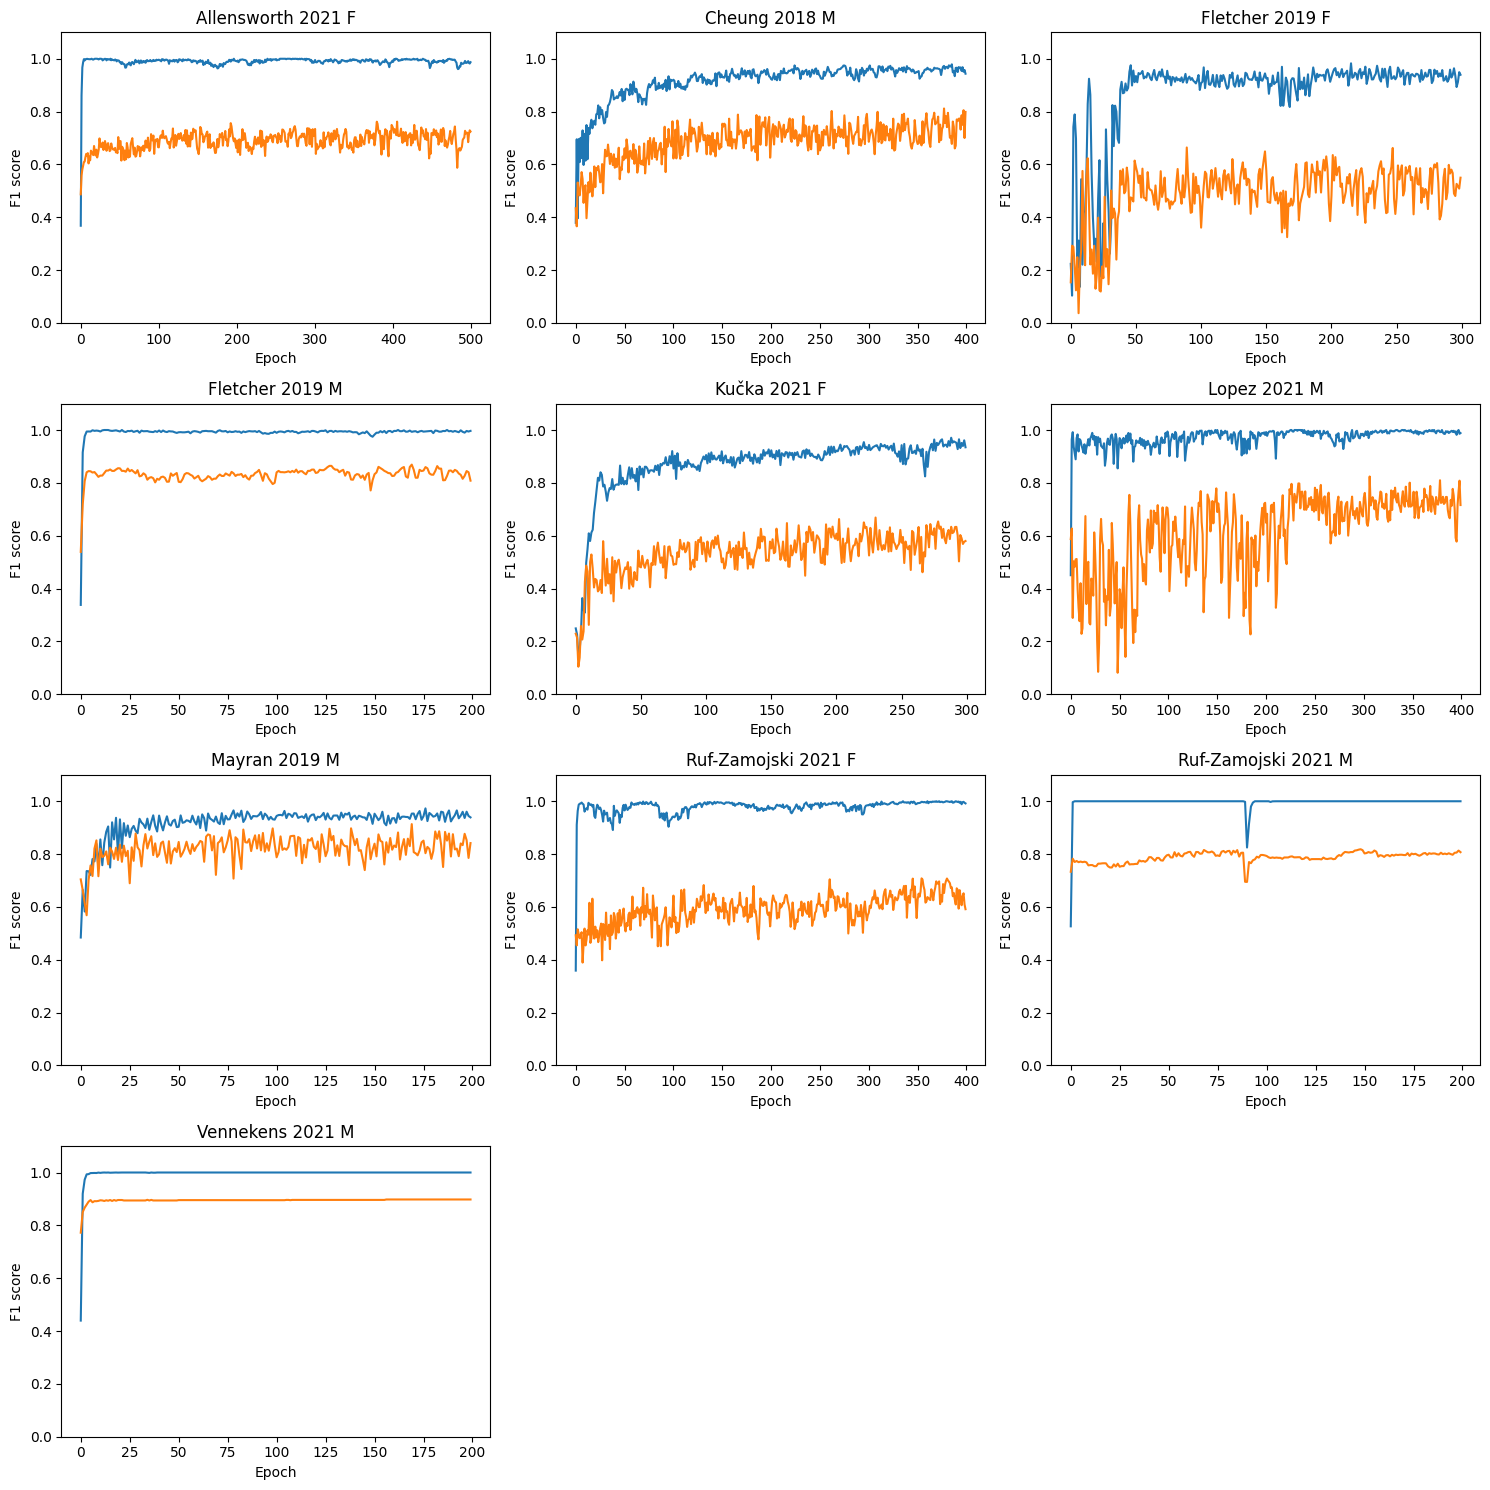

In [6]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))

dataset_names = [
    f"{d['author']} {d['year']} {d['sex']}" for _, d in datasets.iterrows()]
dataset_names = np.unique(dataset_names)
hist_keys = list(trainer.training_histories.keys())

for i, d in enumerate(dataset_names):
    a = ax.ravel()[i]
    a.plot(trainer.training_histories[hist_keys[i]]['macro_f1_score'])
    a.plot(trainer.training_histories[hist_keys[i]]['val_macro_f1_score'])
    a.set_title(d)
    a.set_ylim([0, 1.1])
    a.set_xlabel('Epoch')
    a.set_ylabel('F1 score')

ax.flat[-1].axis('off')
ax.flat[-2].axis('off')
plt.tight_layout()

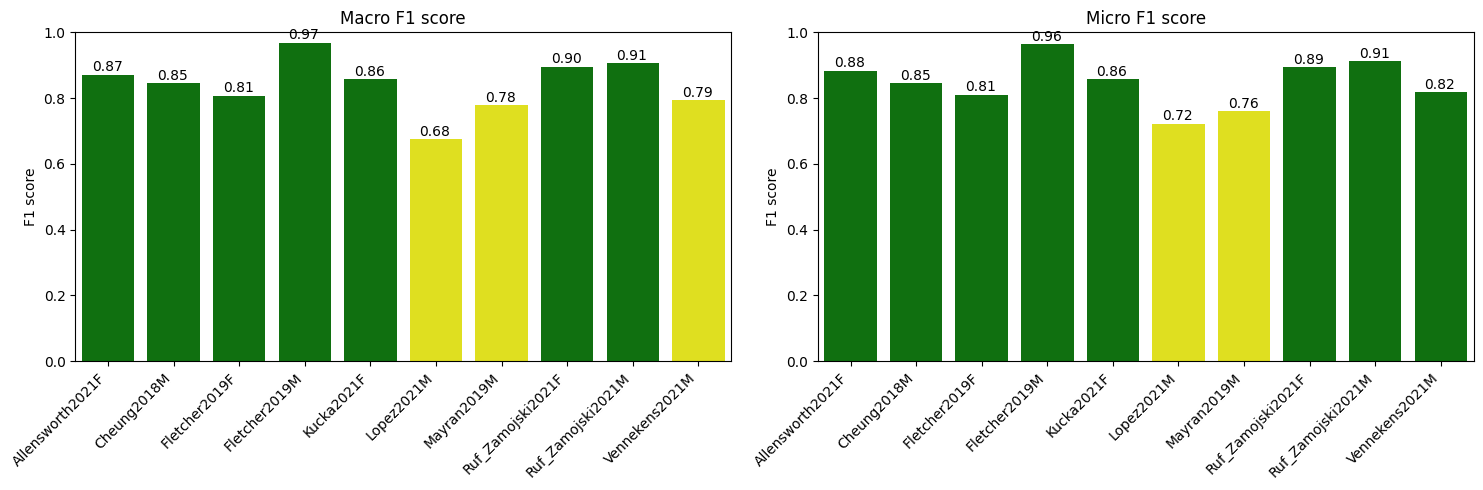

In [12]:
eval_res = trainer.evaluate_models()

macro_f1 = [r["macro_f1_score"] for r in eval_res.values()]
micro_f1 = [r["micro_f1_score"] for r in eval_res.values()]

# barplot of the F1 scores, colored in red if the F1 score is below 0.5, yellow if below 0.8,
# and green otherwise
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=list(eval_res.keys()), y=macro_f1,
            palette=['red' if f < 0.5 else 'yellow' if f < 0.8 else 'green' for f in macro_f1],
            ax=ax[0])
ax[0].set_title('Macro F1 score')
ax[0].set_ylabel('F1 score')
for i, v in enumerate(macro_f1):
    ax[0].text(i - 0.25, v + 0.01, f"{v:.2f}")

sns.barplot(x=list(eval_res.keys()), y=micro_f1,
            palette=['red' if f < 0.5 else 'yellow' if f < 0.8 else 'green' for f in micro_f1],
            ax=ax[1])
ax[1].set_title('Micro F1 score')
ax[1].set_ylabel('F1 score')
for i, v in enumerate(micro_f1):
    ax[1].text(i - 0.25, v + 0.01, f"{v:.2f}")

for a in ax:
    a.set_ylim([0, 1])
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()    

In [8]:
print("\nMean macro F1 score:", np.mean(macro_f1))
print("Median macro F1 score:", np.median(macro_f1))
print("Std macro F1 score:", np.std(macro_f1))


Mean macro F1 score: 0.7491734862327576
Median macro F1 score: 0.740571528673172
Std macro F1 score: 0.09373278934779342
